<a href="https://colab.research.google.com/github/Ciaranguyen/Exoplanets-analysis/blob/main/Exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn numpy

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/My Drive/exoplanets.csv.csv', on_bad_lines='skip', comment='#')
print(df.head())
print(df.info())
print(df.isnull().sum())
df_cleaned = df.dropna(subset=['pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_eqt'])

In [3]:
import numpy as np
earth_values= {
    'radius': 1.0,
    'mass': 1.0,
    'temperature': 288,
    'orbital_period': 365.25
}
def calculate_esi(value, earth_value, alpha=0.5):
  return (1 - abs(value - earth_value) / (value + earth_value)) ** alpha

df_cleaned['esi_radius'] = calculate_esi(df_cleaned['pl_rade'], earth_values['radius'])
df_cleaned['esi_mass'] = calculate_esi(df_cleaned['pl_bmasse'], earth_values['mass'])
df_cleaned['esi_temp'] = calculate_esi(df_cleaned['pl_eqt'], earth_values['temperature'])
df_cleaned['esi_orbital'] = calculate_esi(df_cleaned['pl_orbper'], earth_values['orbital_period'])
df_cleaned['ESI'] = (df_cleaned['esi_radius'] * df_cleaned['esi_mass'] * df_cleaned['esi_temp'] * df_cleaned['esi_orbital']) ** (1/4)

df_sorted = df_cleaned.sort_values(by='ESI', ascending=False)
[print(df_sorted[['pl_name', 'ESI']].head(10))]

            pl_name       ESI
4037   Kepler-452 b  0.870889
2202  Kepler-1126 c  0.861344
3189   Kepler-186 f  0.849716
2463   Kepler-132 e  0.842158
4369    Kepler-69 c  0.842106
2853  Kepler-1605 b  0.830546
2893  Kepler-1638 b  0.826735
4014   Kepler-442 b  0.826633
2282  Kepler-1185 b  0.820416
4013   Kepler-441 b  0.818156


<ipython-input-3-3c77a8c02305>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['esi_radius'] = calculate_esi(df_cleaned['pl_rade'], earth_values['radius'])
<ipython-input-3-3c77a8c02305>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['esi_mass'] = calculate_esi(df_cleaned['pl_bmasse'], earth_values['mass'])
<ipython-input-3-3c77a8c02305>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

[None]

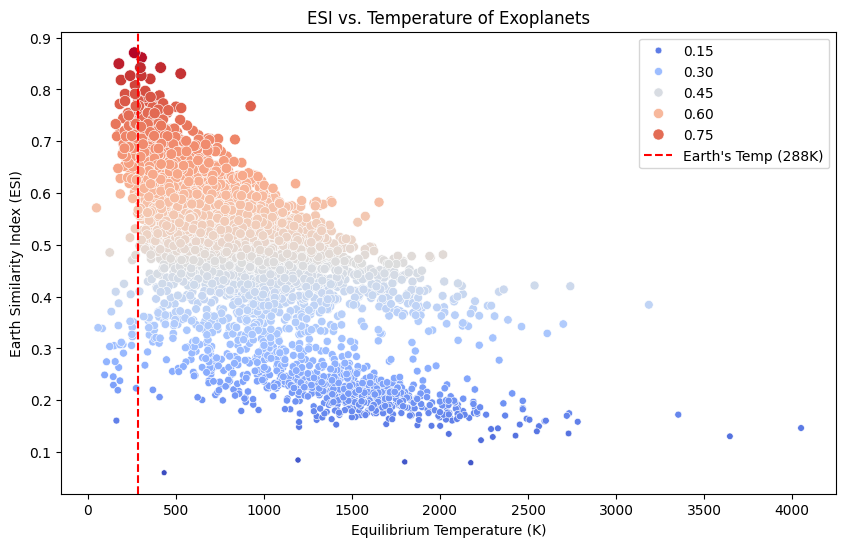

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='pl_eqt', y='ESI', hue='ESI', palette='coolwarm', size='ESI')
plt.axvline(x=288, color='r', linestyle='--', label="Earth's Temp (288K)")
plt.xlabel('Equilibrium Temperature (K)')
plt.ylabel('Earth Similarity Index (ESI)')
plt.title('ESI vs. Temperature of Exoplanets')
plt.legend()
plt.show()

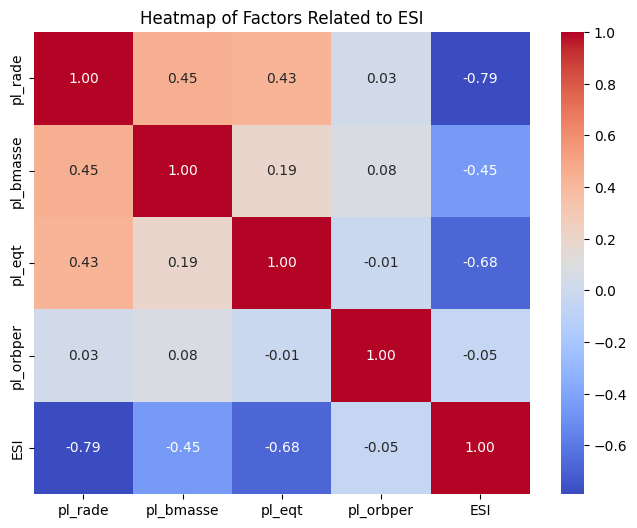

In [5]:
corr = df_cleaned[['pl_rade', 'pl_bmasse', 'pl_eqt', 'pl_orbper', 'ESI']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Factors Related to ESI')
plt.show()

In [6]:
df_cleaned.loc[:, 'has_water'] = (df_cleaned['ESI'] > 0.8).astype(int)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

features = ['pl_rade', 'pl_bmasse', 'pl_eqt', 'pl_orbper']
x = df_cleaned[features]
y = df_cleaned['has_water']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred): .2f}')
print(classification_report(y_test, y_pred))

Accuracy:  1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       853
           1       1.00      0.50      0.67         2

    accuracy                           1.00       855
   macro avg       1.00      0.75      0.83       855
weighted avg       1.00      1.00      1.00       855



<ipython-input-6-14d7bb63f713>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'has_water'] = (df_cleaned['ESI'] > 0.8).astype(int)


In [ ]:
df_sorted[['pl_name', 'ESI']].to_csv("exoplanet_esi_results.csv", index=False)